In [1]:
import warnings
import os
from collections.abc import Iterable

warnings.simplefilter("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# PostBOUND Demo

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import postbound as pb
import seaborn as sns

In [3]:
pg_instance = pb.postgres.connect(config_file="../.psycopg_connection_stats")
pg_instance

stats @ postgres (v17.3)

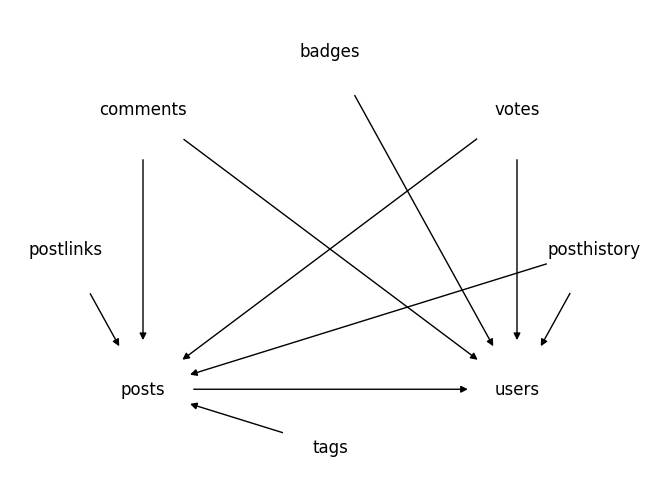

In [4]:
nx.draw_shell(
    pg_instance.schema().as_graph(), with_labels=True, node_size=5000, node_color="#FFF"
)

In [5]:
posts = pb.TableReference("posts", "p")
posts_score = pb.ColumnReference("score", posts)
votes = pb.TableReference("votes", "v")

In [6]:
pg_instance.statistics().most_common_values(posts_score)

[(1, 23221),
 (0, 20196),
 (2, 15478),
 (3, 10068),
 (4, 6320),
 (5, 4208),
 (6, 2893),
 (7, 1975),
 (8, 1331),
 (9, 973)]

## Phase 1: Query Preparation

In [7]:
sample = pb.parse_query("""
    SELECT count(*)
    FROM Posts p, Users u
    WHERE p.OwnerUserId = u.Id
    AND p.Score > 10
""")
sample

SELECT COUNT(*) FROM posts AS p, users AS u WHERE p.owneruserid = u.id AND p.score > 10;

In [8]:
stats = pb.workloads.stats()
stats

Workload: Stats (146 queries)

In [9]:
print(pb.qal.format_quick(stats["q-111"]))

SELECT COUNT(*)
FROM comments AS c,
  postlinks AS pl,
  posthistory AS ph,
  votes AS v,
  posts AS p
WHERE pl.postid = p.id
  AND c.postid = p.id
  AND v.postid = p.id
  AND ph.postid = p.id
  AND pl.linktypeid = 1
  AND pl.creationdate >= CAST('2010-10-19 15:02:42' AS timestamp)
  AND ph.creationdate <= CAST('2014-06-18 17:14:07' AS timestamp)
  AND v.creationdate >= CAST('2010-07-20 00:00:00' AS timestamp);


### Query Abstraction

In [10]:
stats["q-111"].predicates().joins_for(posts)

[pl.postid = p.id, v.postid = p.id, c.postid = p.id, ph.postid = p.id]

### Join Graphs

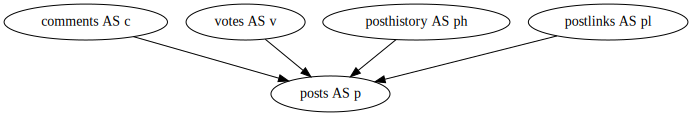

In [11]:
from postbound import vis

join_graph = pb.opt.JoinGraph(stats["q-111"])
vis.opt.plot_join_graph(join_graph, include_pk_fk_joins=True)

In [12]:
join_graph.join_predicates_between(posts, votes)

{v.postid = p.id}

### Relational Algebra

In [13]:
relnode = pb.relalg.parse_relalg(sample)
relnode

Projection(GroupBy(ThetaJoin(Selection(p), u)))

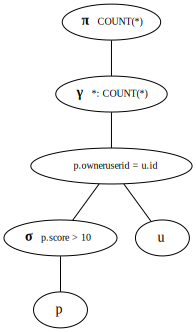

In [14]:
vis.opt.plot_relalg(relnode)

## Phase 2: Query Optimization

In [15]:
print(pb.qal.format_quick(stats["q-10"]))

SELECT COUNT(*)
FROM comments AS c, posts AS p, users AS u
WHERE c.userid = u.id
  AND u.id = p.owneruserid
  AND c.creationdate >= CAST('2010-08-05 00:36:02' AS timestamp)
  AND c.creationdate <= CAST('2014-09-08 16:50:49' AS timestamp)
  AND p.viewcount >= 0
  AND p.viewcount <= 2897
  AND p.commentcount >= 0
  AND p.commentcount <= 16
  AND p.favoritecount >= 0
  AND p.favoritecount <= 10;


In [16]:
from postbound.optimizer.strategies import native

native_join_order = native.NativeJoinOrderOptimizer(pg_instance)
native_operators = native.NativePhysicalOperatorSelection(pg_instance)

In [17]:
pipeline = (
    pb.MultiStageOptimizationPipeline(pg_instance)
    .setup_join_order_optimization(native_join_order)
    .setup_physical_operator_selection(native_operators)
    .build()
)
pipeline

MultiStageOptimization [NativeJoinOrderOptimizer -> NativePhysicalOperatorSelection -> None]

In [18]:
optimized = pipeline.optimize_query(stats["q-10"])
optimized

/*+
  Leading(((c u) p))
  
  SeqScan(c)
  IndexOnlyScan(u)
  IndexOnlyScan(p)
  
  NestLoop(u p c)
  HashJoin(u c)
  
*/
SELECT COUNT(*) FROM comments AS c, posts AS p, users AS u WHERE c.userid = u.id AND u.id = p.owneruserid AND c.creationdate >= CAST('2010-08-05 00:36:02' AS timestamp) AND c.creationdate <= CAST('2014-09-08 16:50:49' AS timestamp) AND p.viewcount >= 0 AND p.viewcount <= 2897 AND p.commentcount >= 0 AND p.commentcount <= 16 AND p.favoritecount >= 0 AND p.favoritecount <= 10;

In [19]:
optimized_plan = pg_instance.optimizer().query_plan(optimized)
print(optimized_plan.ast())

Aggregate
  ->  Gather
    ->  Aggregate
      ->  Nested Loop
        ->  Hash Join
          ->  Seq Scan(comments AS c)
          ->  Hash
            ->  Index Only Scan(users AS u)
        ->  Memoize
          ->  Index Scan(posts AS p)


In [20]:
native_plan = pg_instance.optimizer().query_plan(stats["q-10"])
print(native_plan.ast())

Aggregate
  ->  Gather
    ->  Aggregate
      ->  Nested Loop
        ->  Hash Join
          ->  Seq Scan(comments AS c)
          ->  Hash
            ->  Index Only Scan(users AS u)
        ->  Memoize
          ->  Index Scan(posts AS p)


## Phase 4: Benchmarking

In [21]:
prep = pb.experiments.QueryPreparationService(
    analyze=True, prewarm=True, preparatory_statements=["SET geqo TO off;"]
)

In [22]:
results = pb.optimize_and_execute_workload(
    stats.first(5),
    pipeline,
    workload_repetitions=3,
    shuffled=True,
    query_preparation=prep,
    include_labels=True,
)

In [23]:
results

,label,execution_index,query,workload_iteration,query_repetition,optimization_time,exec_time,query_result,optimization_success,optimization_failure_reason,original_query,optimization_settings,db_config
0,q-3,1,"SELECT COUNT(*) FROM comments AS c, posthistor...",1,1,0.004942,0.222258,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, posthistor...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
1,q-5,2,"SELECT COUNT(*) FROM comments AS c, votes AS v...",1,1,0.004106,0.384566,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, votes AS v...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
2,q-4,3,"SELECT COUNT(*) FROM comments AS c, posthistor...",1,1,0.003991,0.198434,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, posthistor...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
3,q-1,4,"SELECT COUNT(*) FROM badges AS b, users AS u W...",1,1,0.003881,0.028059,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM badges AS b, users AS u W...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
4,q-2,5,"SELECT COUNT(*) FROM comments AS c, badges AS ...",1,1,0.003639,0.531290,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, badges AS ...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
5,q-4,6,"SELECT COUNT(*) FROM comments AS c, posthistor...",2,1,0.003987,0.192644,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, posthistor...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
6,q-1,7,"SELECT COUNT(*) FROM badges AS b, users AS u W...",2,1,0.003735,0.035504,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM badges AS b, users AS u W...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
7,q-3,8,"SELECT COUNT(*) FROM comments AS c, posthistor...",2,1,0.003882,0.219210,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, posthistor...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
8,q-5,9,"SELECT COUNT(*) FROM comments AS c, votes AS v...",2,1,0.003934,0.382941,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, votes AS v...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
9,q-2,10,"SELECT COUNT(*) FROM comments AS c, badges AS ...",2,1,0.003982,0.531723,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",True,None,"SELECT COUNT(*) FROM comments AS c, badges AS ...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."


In [24]:
avg_runtimes = results.groupby("label", as_index=False)["exec_time"].mean()
avg_runtimes

,label,exec_time
0,q-1,0.030441
1,q-2,0.531027
2,q-3,0.221231
3,q-4,0.193638
4,q-5,0.383782


<Axes: xlabel='label', ylabel='exec_time'>

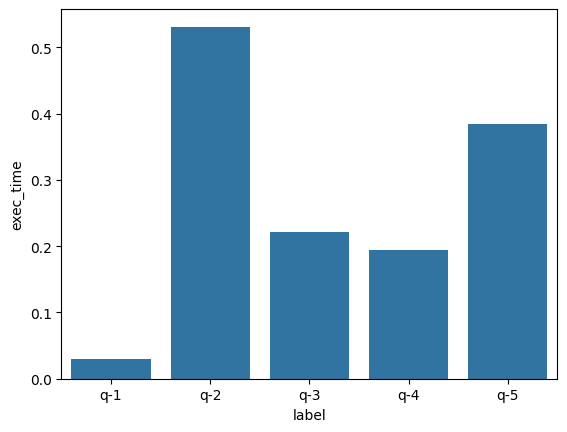

In [25]:
sns.barplot(avg_runtimes, x="label", y="exec_time")

## Example: MSCN-*light*

In [26]:
import numpy as np
import sentence_transformers as st
from sklearn.ensemble import GradientBoostingRegressor

embedding = st.SentenceTransformer("all-MiniLM-L6-v2")

In [27]:
query = stats["q-10"]
query

SELECT COUNT(*) FROM comments AS c, posts AS p, users AS u WHERE c.userid = u.id AND u.id = p.owneruserid AND c.creationdate >= CAST('2010-08-05 00:36:02' AS timestamp) AND c.creationdate <= CAST('2014-09-08 16:50:49' AS timestamp) AND p.viewcount >= 0 AND p.viewcount <= 2897 AND p.commentcount >= 0 AND p.commentcount <= 16 AND p.favoritecount >= 0 AND p.favoritecount <= 10;

In [43]:
tables = query.tables()
joins = query.predicates().joins()
filters = query.predicates().filters()
tables, joins, filters

({TableReference(full_name='comments', alias='c', virtual=False, schema=''),
  TableReference(full_name='posts', alias='p', virtual=False, schema=''),
  TableReference(full_name='users', alias='u', virtual=False, schema='')},
 {c.userid = u.id, u.id = p.owneruserid},
 {c.creationdate <= CAST('2014-09-08 16:50:49' AS timestamp),
  c.creationdate >= CAST('2010-08-05 00:36:02' AS timestamp),
  p.commentcount <= 16,
  p.commentcount >= 0,
  p.favoritecount <= 10,
  p.favoritecount >= 0,
  p.viewcount <= 2897,
  p.viewcount >= 0})

In [44]:
tables_feature = embedding.encode([str(tables)])
joins_feature = embedding.encode([str(joins)])
filters_feature = embedding.encode([str(filters)])
np.concat([tables_feature, joins_feature, filters_feature], axis=1)[0]

array([-0.00227349, -0.02548493, -0.03711659, ...,  0.02383064,
       -0.02026955,  0.09278111], shape=(1152,), dtype=float32)

In [45]:
def featurize(query: pb.SqlQuery) -> np.ndarray:
    tables = query.tables()
    joins = query.predicates().joins()
    filters = query.predicates().filters()

    tables_feature = embedding.encode([str(tables)])
    joins_feature = embedding.encode([str(joins)])
    filters_feature = embedding.encode([str(filters)])
    
    return np.concat(
        [tables_feature, joins_feature, filters_feature],
    axis=1)[0]

In [31]:
class MSCNlight(pb.CardinalityGenerator):
    def __init__(self) -> None:
        super().__init__(False)
        self.model = GradientBoostingRegressor()

    def calculate_estimate(self, query: pb.SqlQuery,
        tables: pb.TableReference | Iterable[pb.TableReference],
    ) -> pb.Cardinality:
        pass

    def describe(self):
        return {"name": "mscn-light", "embedding": "all-MiniLM-L6-v2"}

In [32]:
class MSCNlight(pb.CardinalityGenerator):
    def __init__(self) -> None:
        super().__init__(False)
        self.model = GradientBoostingRegressor()
        
    def calculate_estimate(self, query: pb.SqlQuery,
        tables: pb.TableReference | Iterable[pb.TableReference]
    ) -> pb.Cardinality:
        subquery = pb.transform.extract_query_fragment(query, tables)
        featurized = featurize(subquery)
        prediction = self.model.predict([featurized])[0]
        return pb.Cardinality(max(prediction, 0))

    def describe(self):
        return {"name": "mscn-light", "embedding": "all-MiniLM-L6-v2"}

In [46]:
class MSCNlight(pb.CardinalityGenerator):
    def __init__(self) -> None:
        super().__init__(False)
        self.model = GradientBoostingRegressor()

    def train(self, samples: pd.DataFrame) -> None:
        samples["featurized"] = (samples["query"]
                                 .map(pb.parse_query)
                                 .map(featurize))
        featurized = np.stack(samples["featurized"])
        self.model.fit(featurized, samples["cardinality"])
    
    def calculate_estimate(self, query: pb.SqlQuery,
        tables: pb.TableReference | Iterable[pb.TableReference]
    ) -> pb.Cardinality:
        subquery = pb.transform.extract_query_fragment(query, tables)
        featurized = featurize(subquery)
        prediction = self.model.predict([featurized])[0]
        return pb.Cardinality(max(prediction, 0))

    def describe(self):
        return {"name": "mscn-light", "embedding": "all-MiniLM-L6-v2"}

In [34]:
training_samples = pd.read_csv("../data/cardinality-samples.csv")
training_samples

,query,cardinality
0,"SELECT COUNT(*)\nFROM users,\n badges,\n vot...",50639
1,"SELECT COUNT(*)\nFROM posts, votes\nWHERE vote...",328064
2,"SELECT COUNT(*)\nFROM posts, users\nWHERE post...",60
3,"SELECT COUNT(*)\nFROM posts, posthistory\nWHER...",15686
4,"SELECT COUNT(*)\nFROM comments, users\nWHERE c...",143120
...,...,...
995,"SELECT COUNT(*)\nFROM users, comments, votes\n...",2969835
996,"SELECT COUNT(*)\nFROM posthistory, posts, user...",2216
997,"SELECT COUNT(*)\nFROM posthistory,\n users,\n...",83133
998,"SELECT COUNT(*)\nFROM tags, posts\nWHERE tags....",9


In [35]:
mscn_light = MSCNlight()
mscn_light.train(training_samples)

In [36]:
optimizer = (
    pb.MultiStageOptimizationPipeline(pg_instance)
    .setup_plan_parameterization(mscn_light)
    .build()
)
optimizer

MultiStageOptimization [None -> None -> MSCNlight]

In [37]:
optimizer.optimize_query(query)

/*+
  
  Rows(p u #0)
  Rows(u c #270177913)
  Rows(u p c #73353107)
*/
SELECT COUNT(*) FROM comments AS c, posts AS p, users AS u WHERE c.userid = u.id AND u.id = p.owneruserid AND c.creationdate >= CAST('2010-08-05 00:36:02' AS timestamp) AND c.creationdate <= CAST('2014-09-08 16:50:49' AS timestamp) AND p.viewcount >= 0 AND p.viewcount <= 2897 AND p.commentcount >= 0 AND p.commentcount <= 16 AND p.favoritecount >= 0 AND p.favoritecount <= 10;

In [38]:
test_workload = pb.workloads.read_workload("../workload/")
test_workload

Workload: workload (5 queries)

In [39]:
native_results = pb.execute_workload(
    test_workload, pg_instance, timeout=15, include_labels=True
)
native_results

,label,execution_index,query,workload_iteration,query_repetition,exec_time,query_result
0,q-28,1,"SELECT COUNT(*) FROM votes AS v, posts AS p, b...",1,1,0.500072,16049150
1,q-30,2,"SELECT COUNT(*) FROM votes AS v, posts AS p, b...",1,1,12.450135,232039659
2,q-52,3,"SELECT COUNT(*) FROM comments AS c, posts AS p...",1,1,4.920209,228748307
3,q-56,4,"SELECT COUNT(*) FROM tags AS t, posts AS p, us...",1,1,1.253583,15887370
4,q-140,5,"SELECT COUNT(*) FROM comments AS c, posts AS p...",1,1,10.338786,113925678


In [40]:
mscn_results = pb.optimize_and_execute_workload(
    test_workload, optimizer, timeout=15, include_labels=True
)
mscn_results

,label,execution_index,query,workload_iteration,query_repetition,optimization_time,exec_time,query_result,optimization_success,optimization_failure_reason,original_query,optimization_settings,db_config
0,q-28,1,"SELECT COUNT(*) FROM votes AS v, posts AS p, b...",1,1,0.514706,0.889347,16049150,True,None,"SELECT COUNT(*) FROM votes AS v, posts AS p, b...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
1,q-30,2,"SELECT COUNT(*) FROM votes AS v, posts AS p, b...",1,1,0.389733,12.396393,232039659,True,None,"SELECT COUNT(*) FROM votes AS v, posts AS p, b...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
2,q-52,3,"SELECT COUNT(*) FROM comments AS c, posts AS p...",1,1,1.100961,inf,None,True,None,"SELECT COUNT(*) FROM comments AS c, posts AS p...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
3,q-56,4,"SELECT COUNT(*) FROM tags AS t, posts AS p, us...",1,1,0.776065,13.095258,15887370,True,None,"SELECT COUNT(*) FROM tags AS t, posts AS p, us...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."
4,q-140,5,"SELECT COUNT(*) FROM comments AS c, posts AS p...",1,1,2.217497,3.097654,113925678,True,None,"SELECT COUNT(*) FROM comments AS c, posts AS p...","{'name': 'multi_stage_pipeline', 'database_sys...","{'system_name': 'postgres', 'system_version': ..."


In [41]:
results = pd.concat(
    [native_results.assign(optimizer="PG"),
     mscn_results.assign(optimizer="MSCN")],
    ignore_index=True,
)

<Axes: xlabel='label', ylabel='exec_time'>

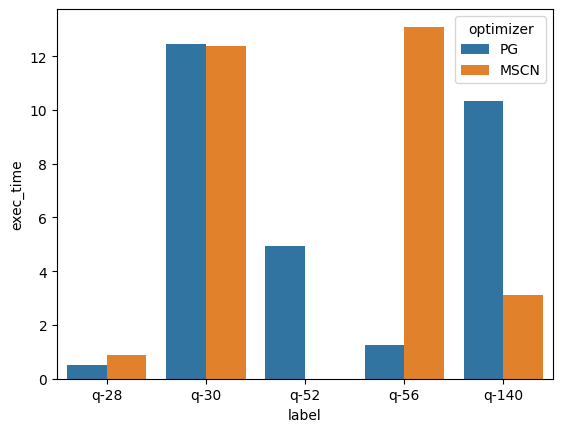

In [42]:
sns.barplot(results, x="label", y="exec_time", hue="optimizer")